# **INT303 Big Data Analytics (2425 S1) Assignment 2**
# Leveraging Random Forest for Predicting Student Academic Trajectory

* Mingyuan Li
* 2145618

# **1. Exploratory Data Analysis**
Exploratory Data Analysis (EDA) is a critical step in data processing method that involves summarizing, visualizing, and interpreting datasets to uncover hidden patterns, relationships, and anomalies. The primary motivation for conducting EDA is to gain a deeper understanding of the data, which enables the development of more accurate and robust machine learning models. By exploring the provided dataset, which includes diverse features such as demographic, academic, and socioeconomic variables, EDA aims to identify potential relationships and insights that can enhance predictive performance in subsequent machine learning task.
## Data interpretation and cleaning
Data interpretation and cleaning is the foundational step in preparing the dataset for analysis, focusing on initial inspections to detect missing values, outliers, and potential data type mismatches. 

In [1]:
# read data from csv file
import pandas as pd
data = pd.read_csv('/kaggle/input/int-303-big-data-analytics-2425-s1/train.csv') 
# print the basic holistic information of the data
print(data.info())
# print the detailed description of the data
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3539 entries, 0 to 3538
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   ID                                              3539 non-null   int64  
 1   Marital status                                  3539 non-null   int64  
 2   Application mode                                3539 non-null   int64  
 3   Application order                               3539 non-null   int64  
 4   Course                                          3539 non-null   int64  
 5   Daytime/evening attendance                      3539 non-null   int64  
 6   Previous qualification                          3539 non-null   int64  
 7   Nacionality                                     3539 non-null   int64  
 8   Mother's qualification                          3539 non-null   int64  
 9   Father's qualification                   

According to the results above, a thorough examination revealed that there are no missing values, and no apparent outliers. This clean and well-structured dataset ensures a solid basis for further exploratory data analysis and predictive modeling.

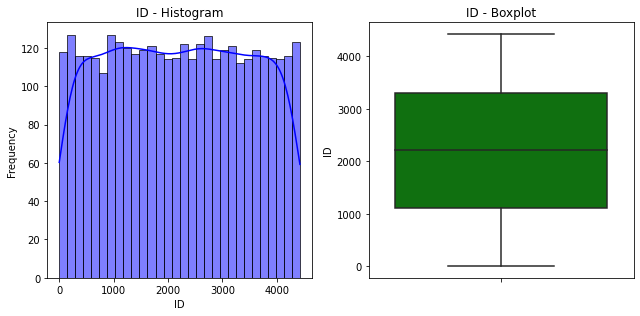

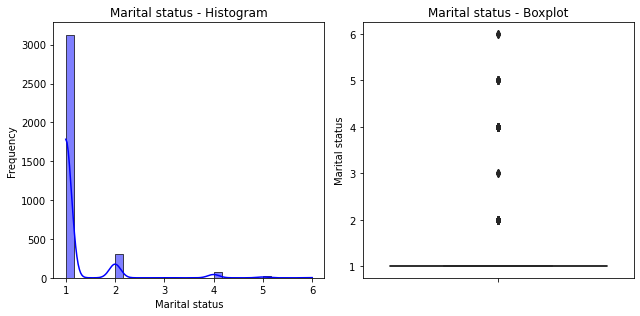

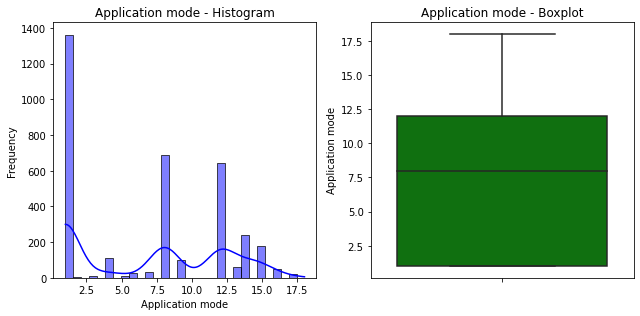

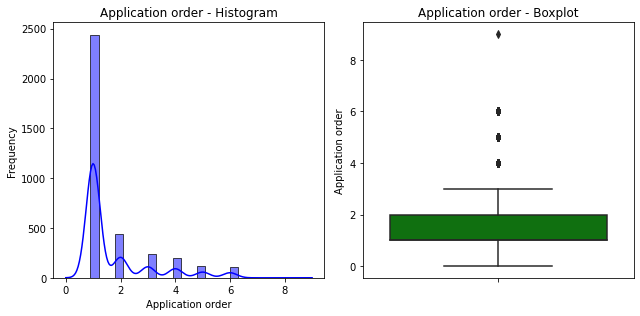

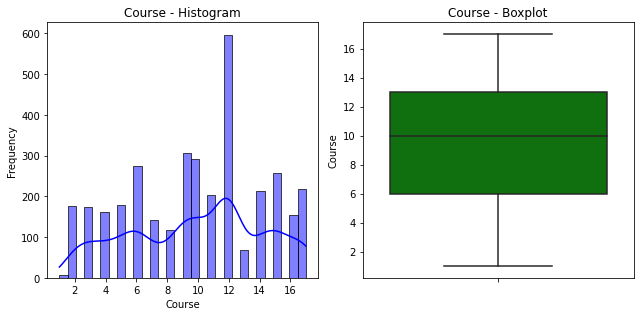

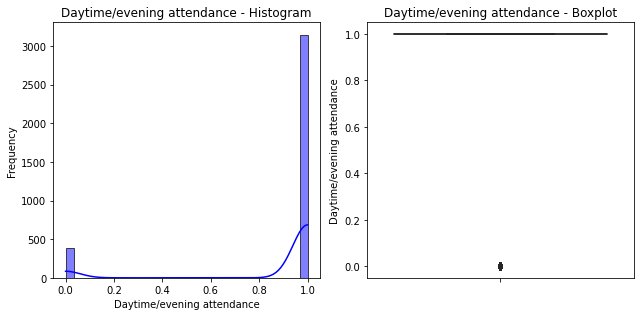

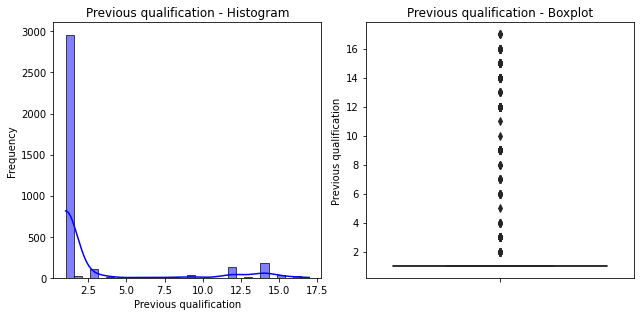

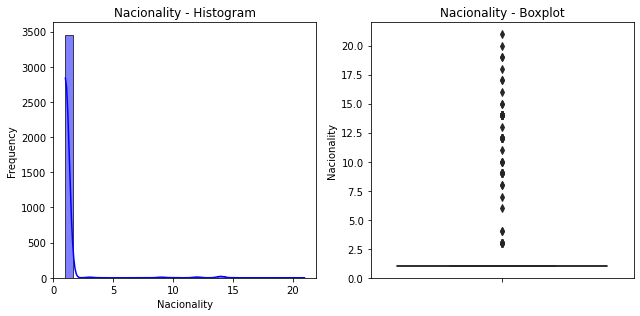

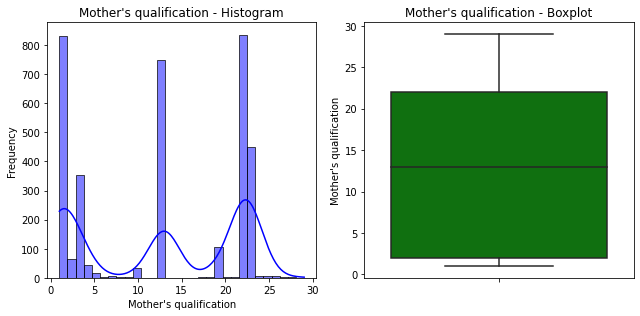

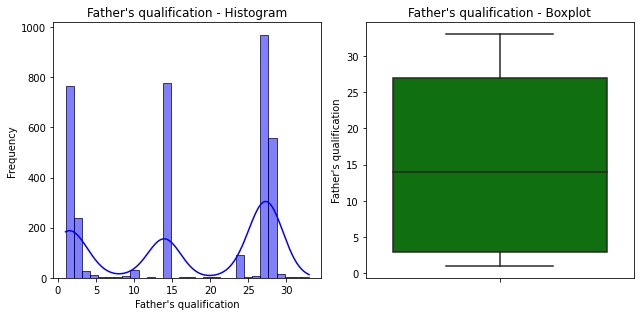

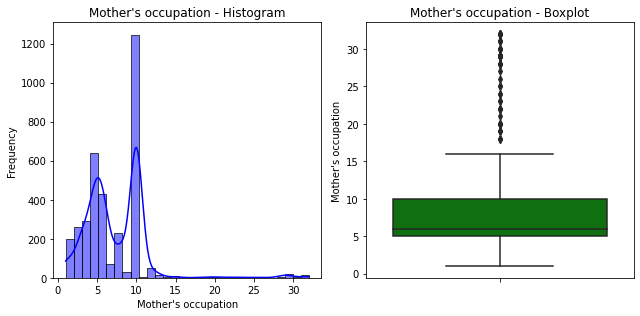

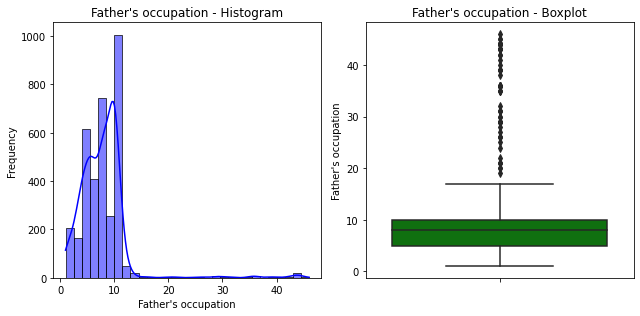

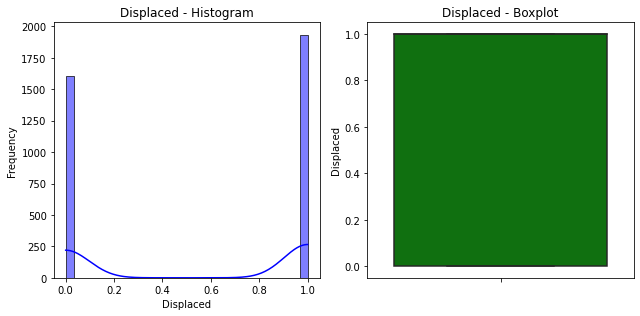

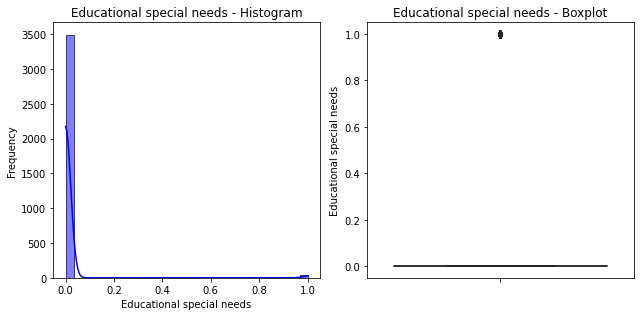

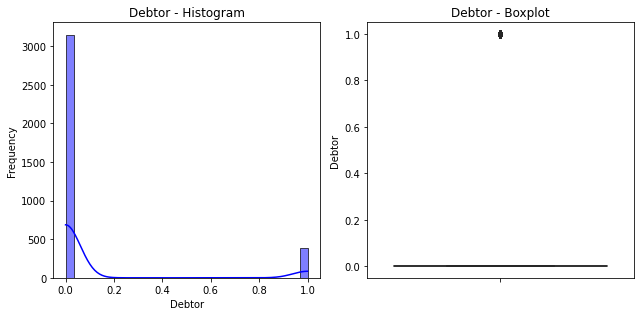

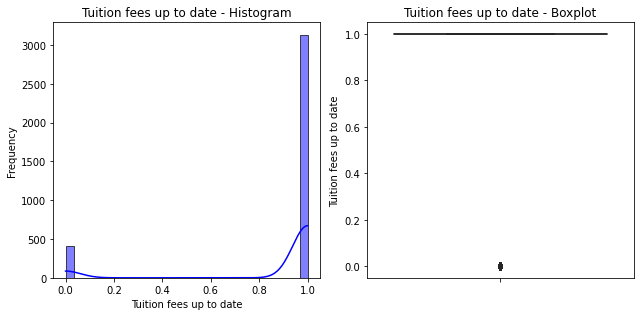

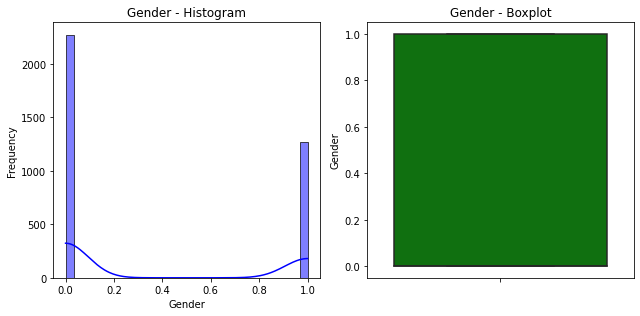

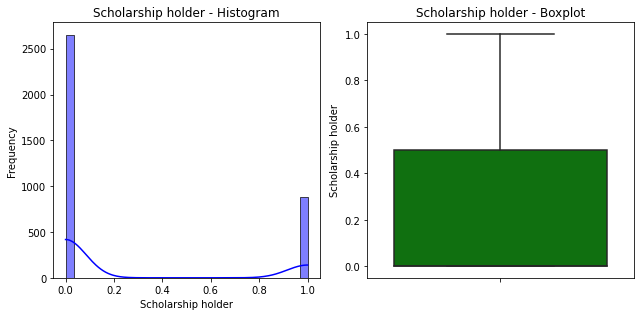

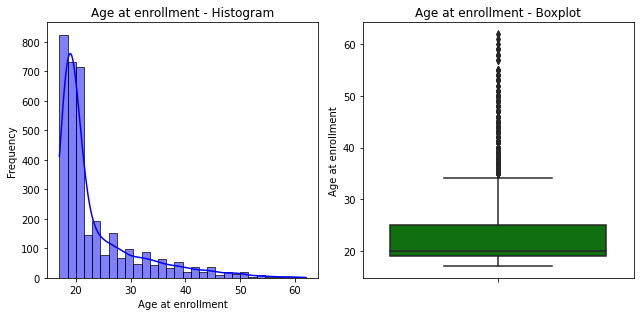

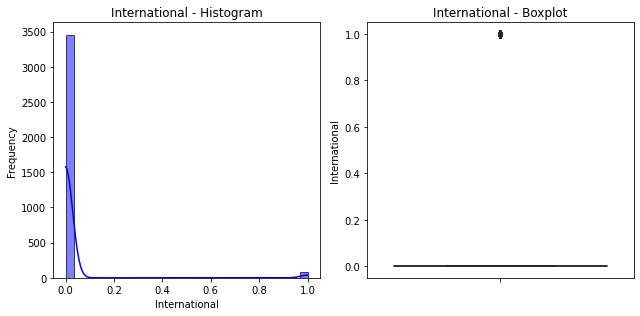

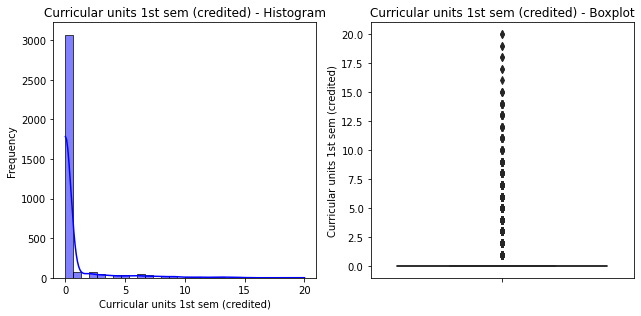

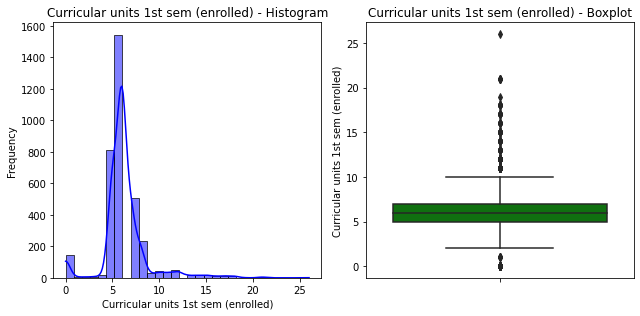

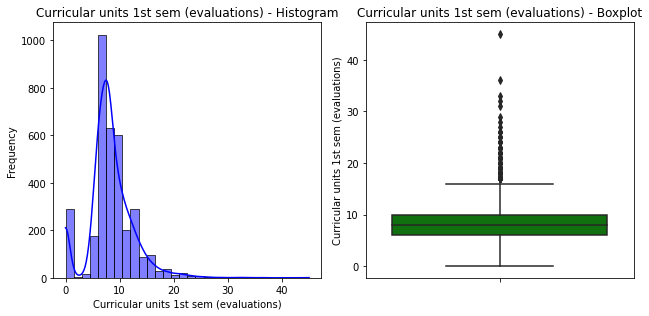

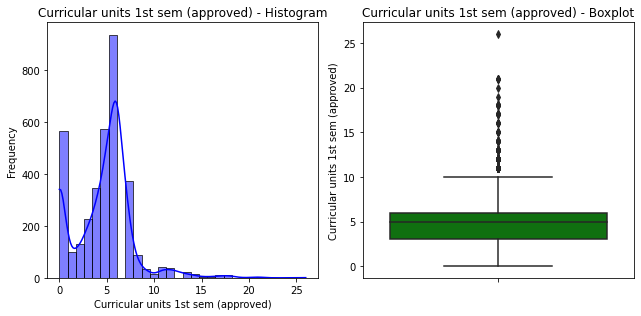

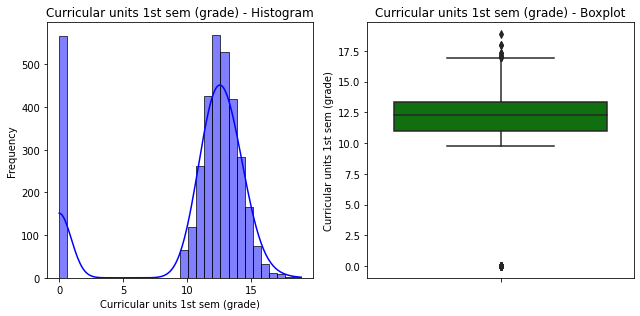

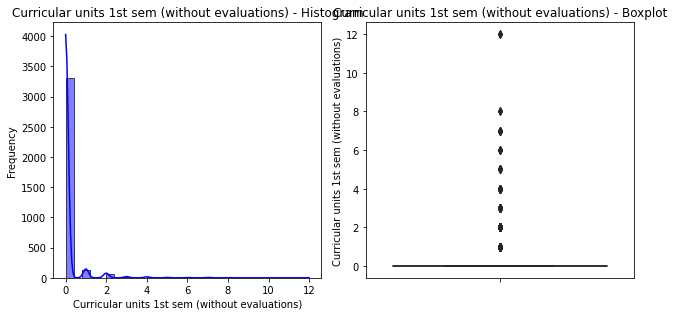

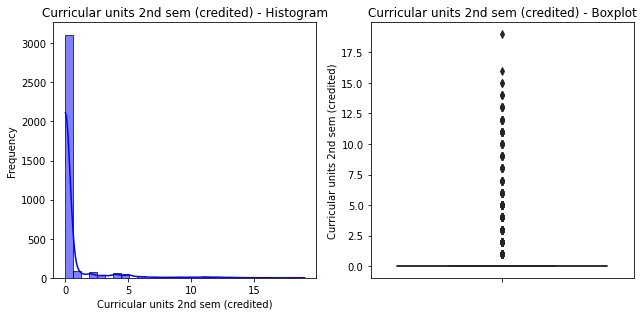

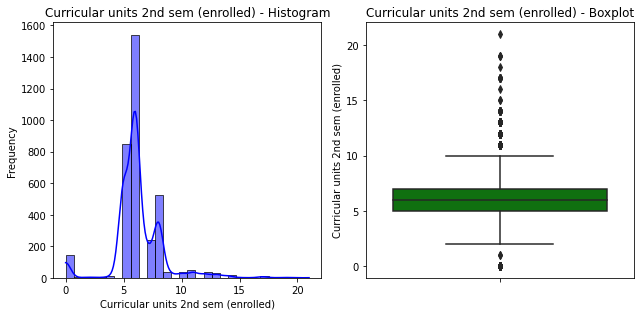

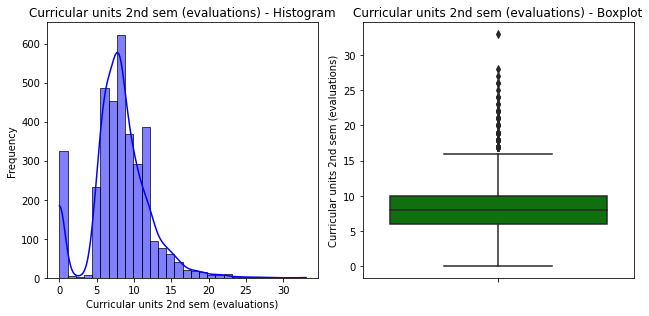

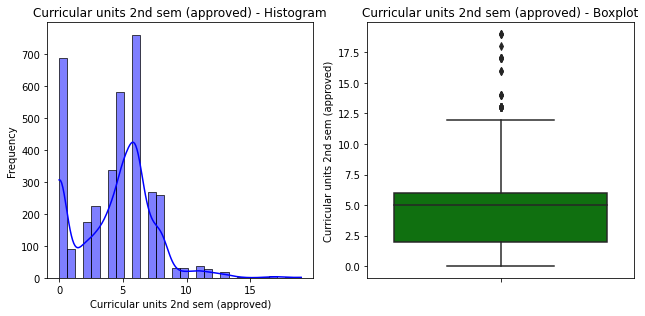

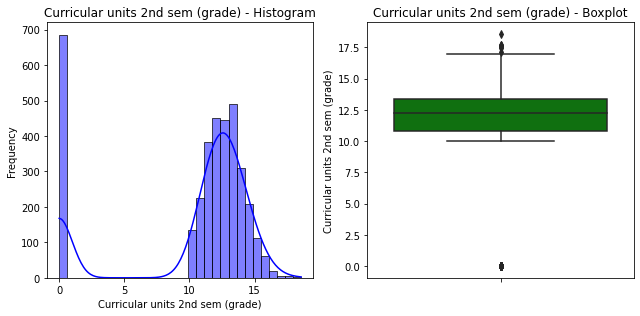

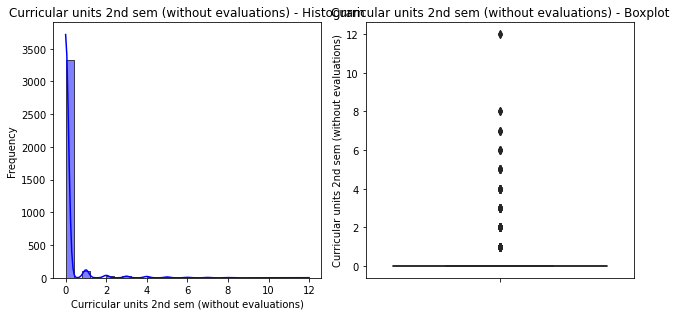

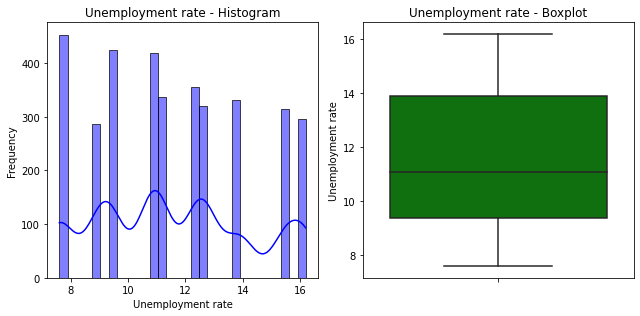

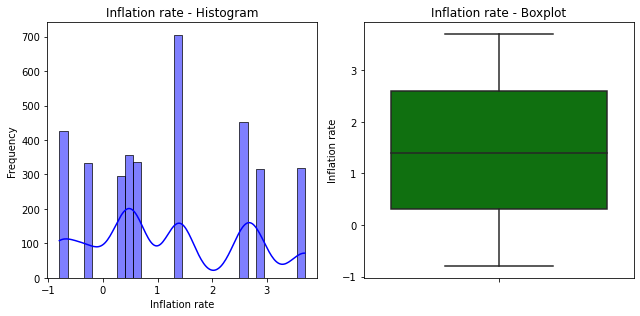

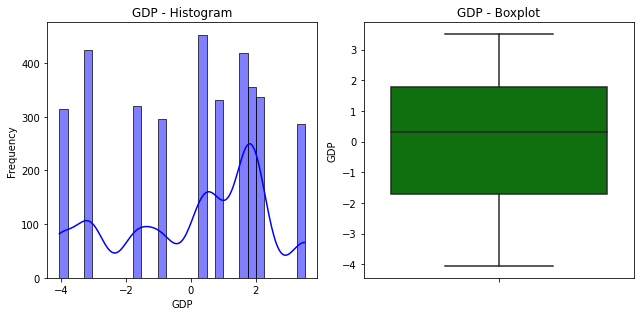

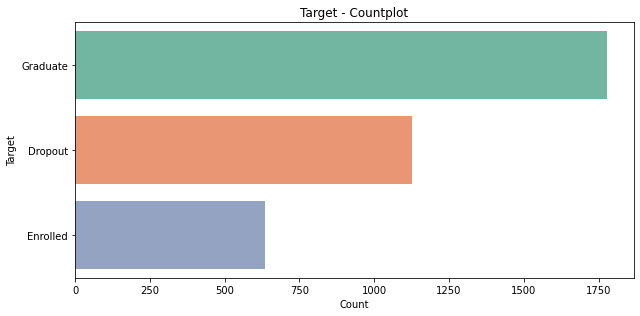

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# function to plot univariate analysis
def plot_univariate_analysis(data):

    for column in data.columns:
        plt.figure(figsize=(9, 4.5))
        # If the column is numeric, plot histogram and boxplot
        if pd.api.types.is_numeric_dtype(data[column]):
            # draw histogram
            plt.subplot(1, 2, 1)
            sns.histplot(data[column], kde=True, bins=30, color='blue')
            plt.title(f'{column} - Histogram')
            plt.xlabel(column)
            plt.ylabel('Frequency')

            # draw boxplot
            plt.subplot(1, 2, 2)
            sns.boxplot(y=data[column], color='green')
            plt.title(f'{column} - Boxplot')
            plt.ylabel(column)
        else:
            # If the column is categorical, plot countplot
            sns.countplot(y=data[column], palette='Set2')
            plt.title(f'{column} - Countplot')
            plt.xlabel('Count')
            plt.ylabel(column)

        plt.tight_layout()
        plt.show()

plot_univariate_analysis(data)


The distribution of 35 features was analyzed using histograms and boxplots. The results indicate that most features exhibit dispersed and uneven distributions. The boxplots reveal a significant presence of outliers, necessitating further investigation into the correlations between features.

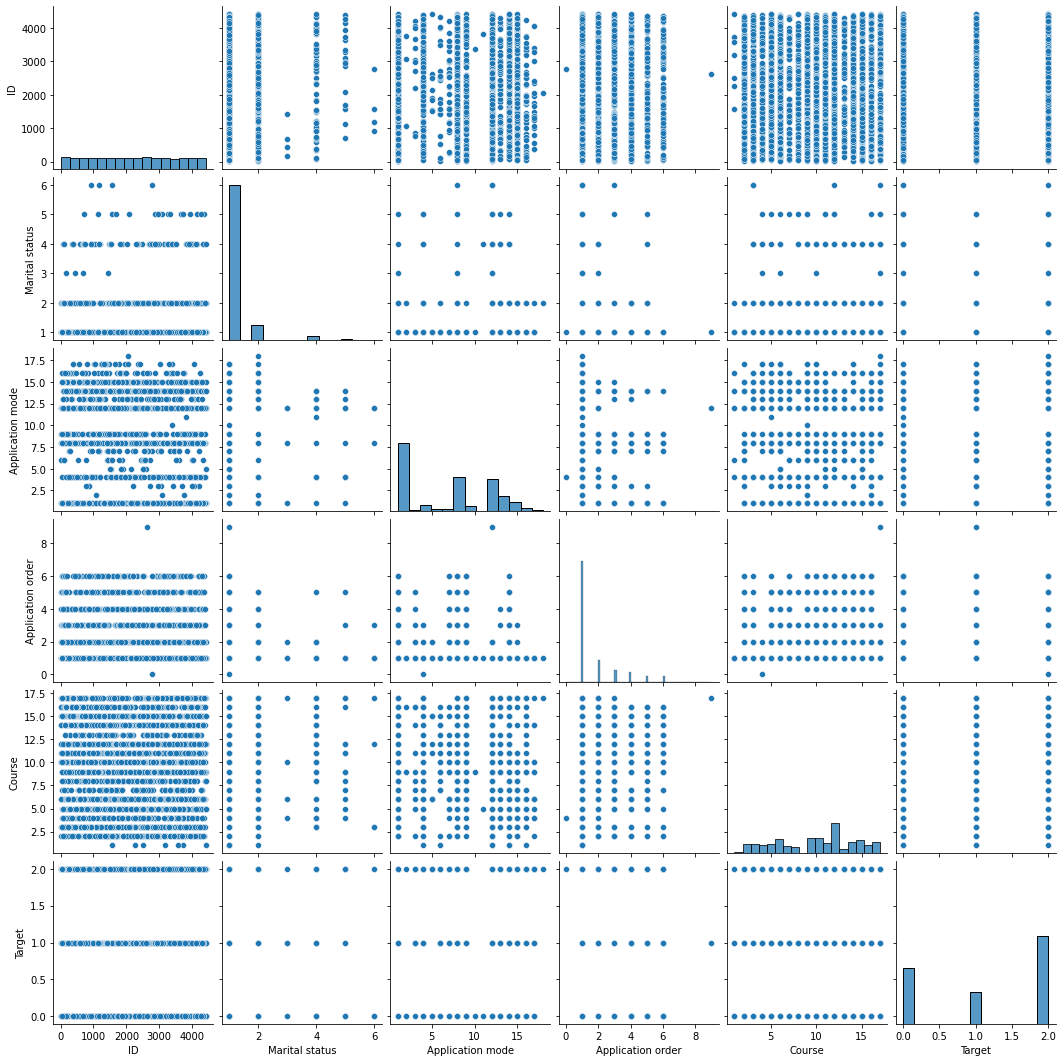

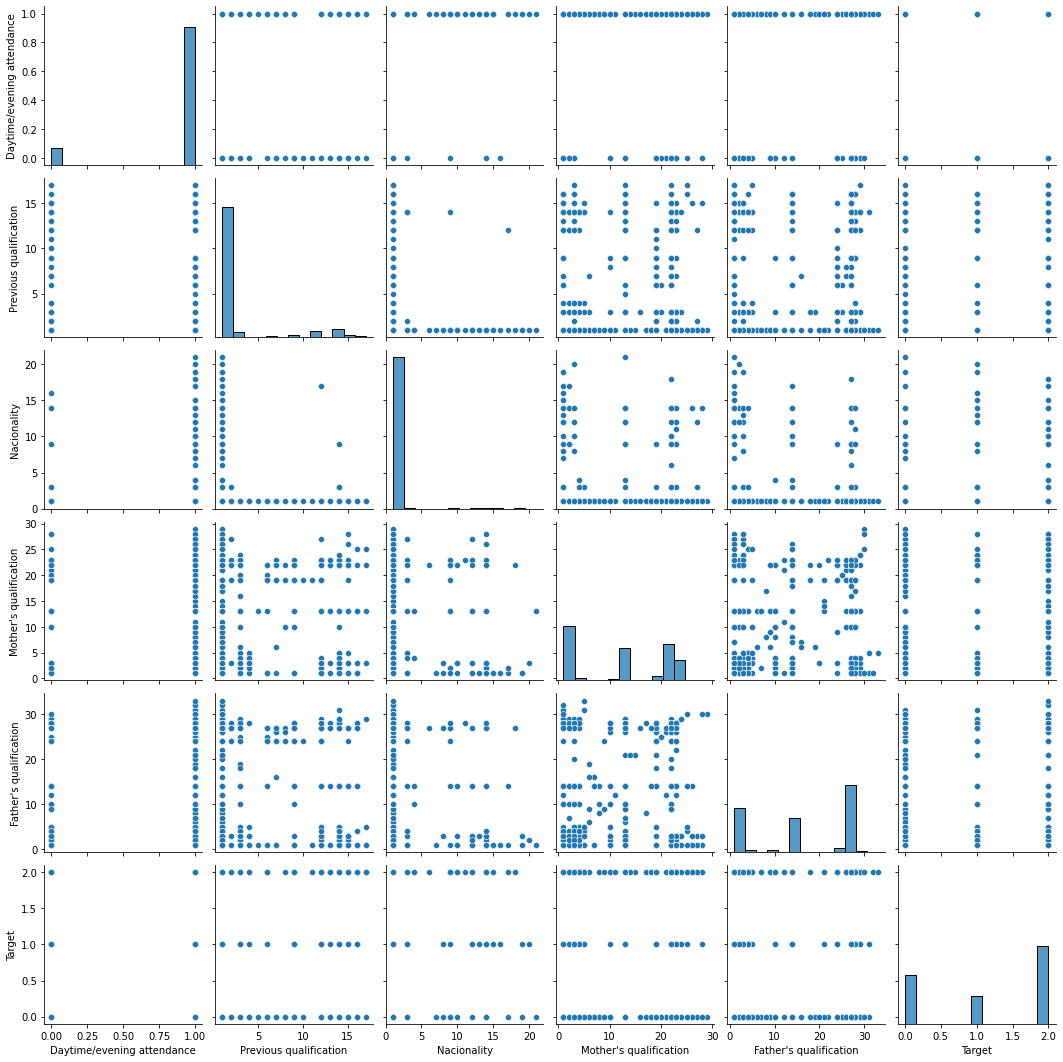

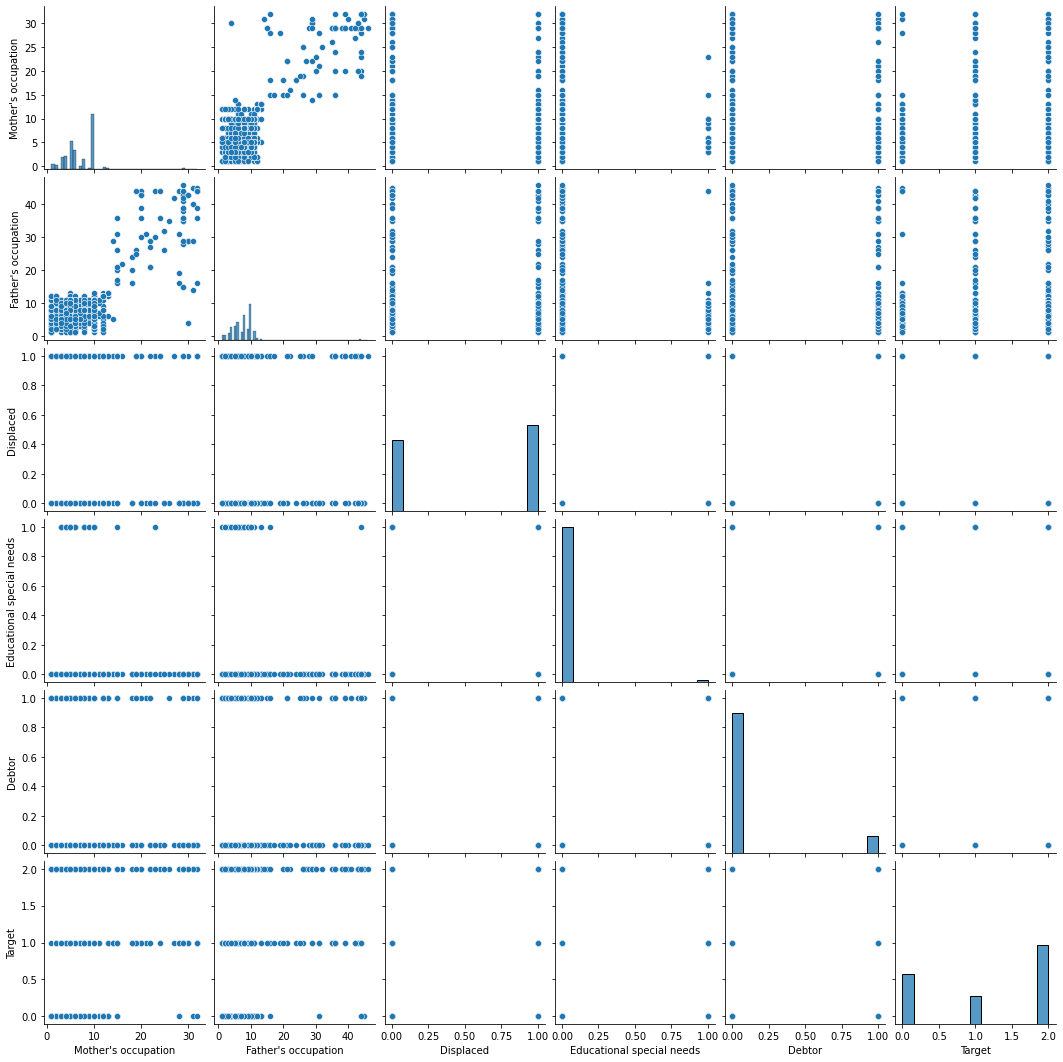

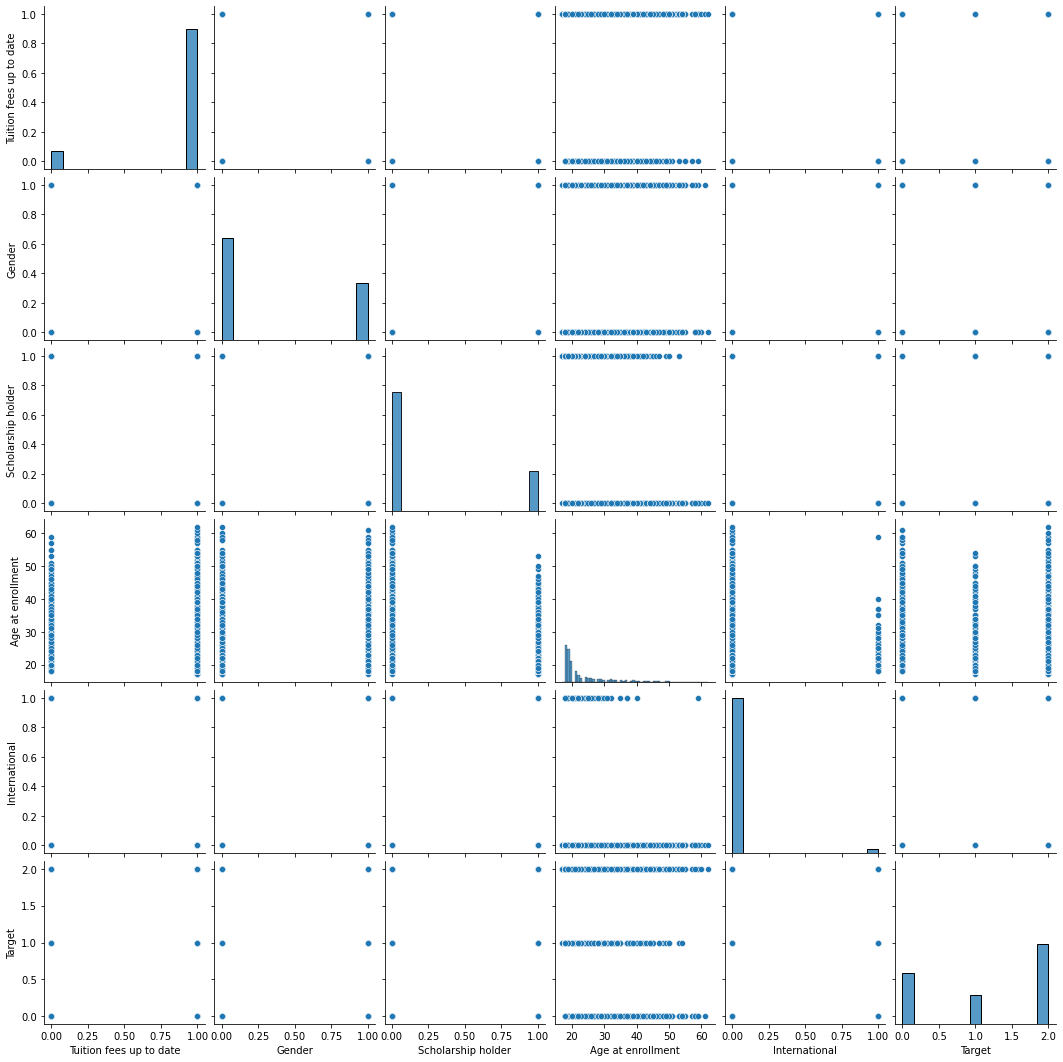

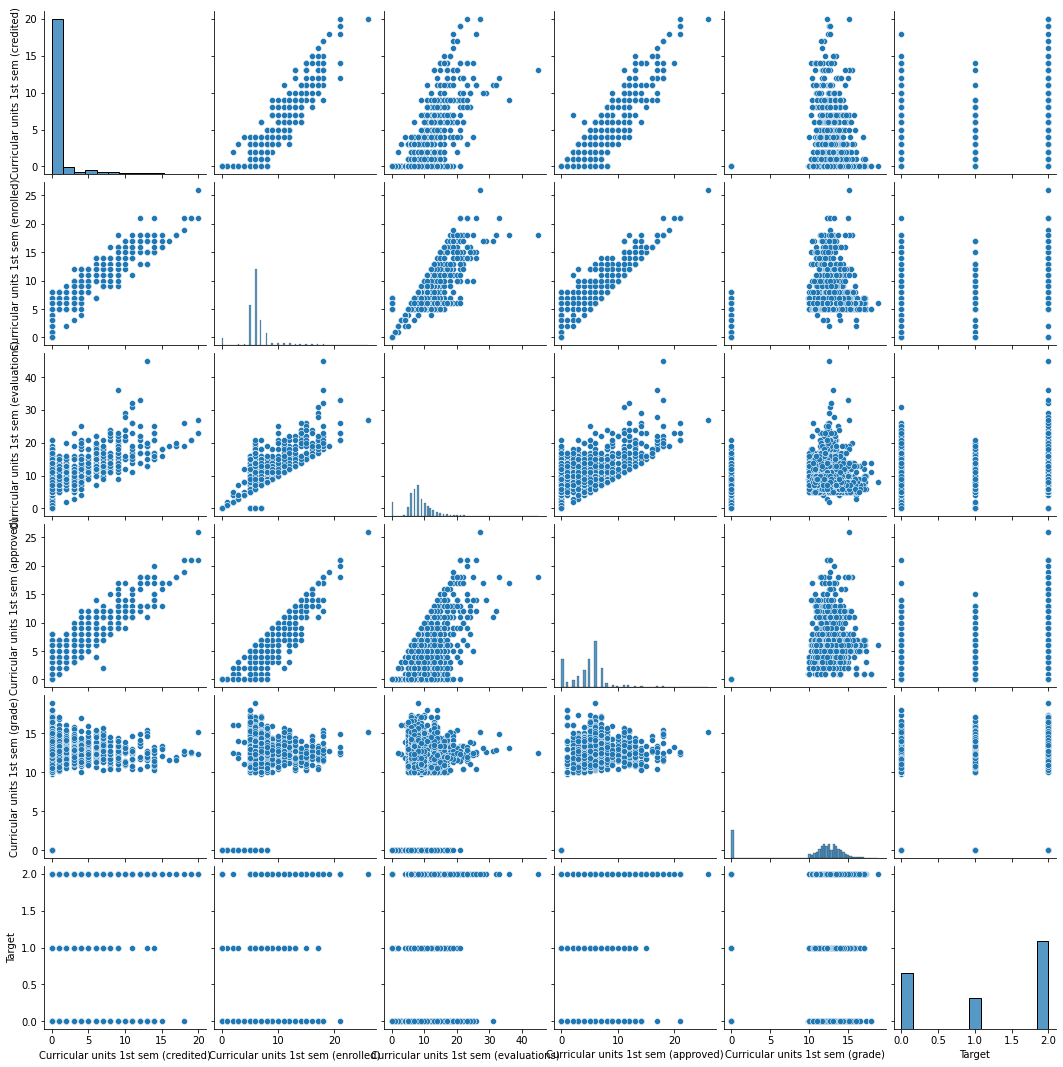

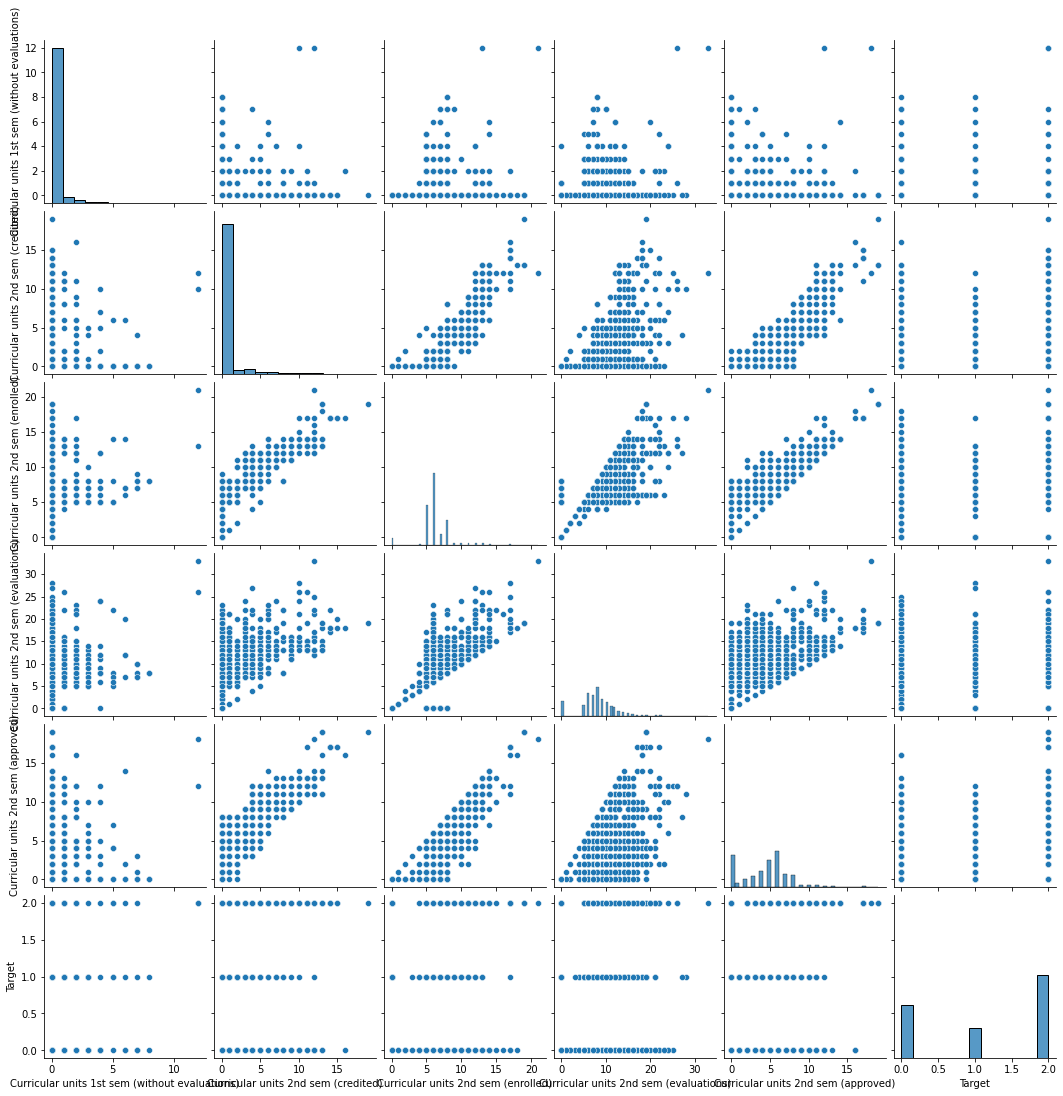

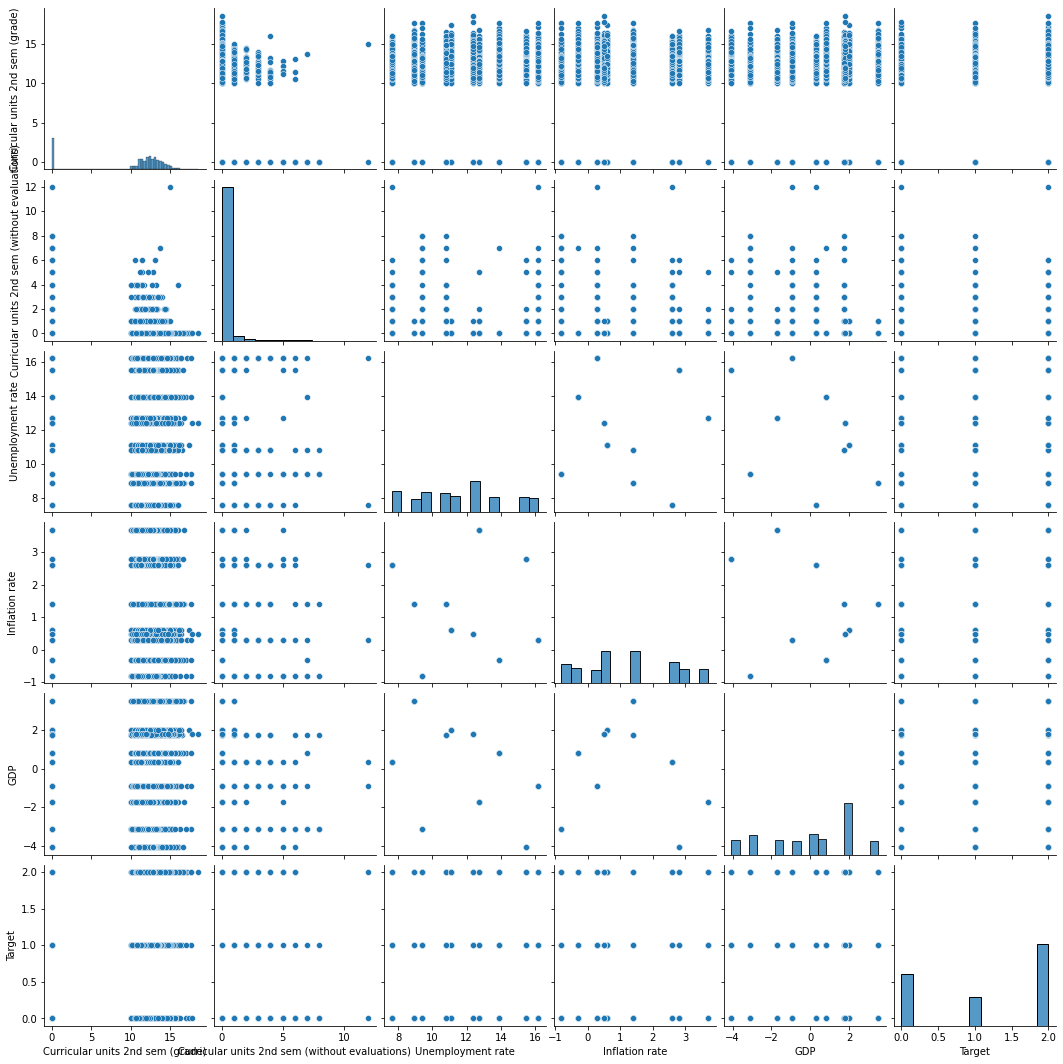

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# function to plot pairplots
def plot_pairplots(data, target_column, cols_per_plot=5):
    columns = data.columns.tolist()
    columns.remove(target_column)

    # iterate over the columns
    for i in range(0, len(columns), cols_per_plot):
        subset = columns[i:i + cols_per_plot]
        subset_with_target = subset + [target_column]
        data_subset = data[subset_with_target]
        
        sns.pairplot(data_subset)
        plt.show()

plot_pairplots(data, target_column='Target')


To explore these correlations, pairplots were initially employed. Given the large number of features, only five selected features along with the target variable were visualized to examine potential relationships with the target. The findings suggest that most feature pairs show no significant correlation, except for strong associations observed between socioeconomic data and academic performance at the end of the 1st and 2nd semesters.

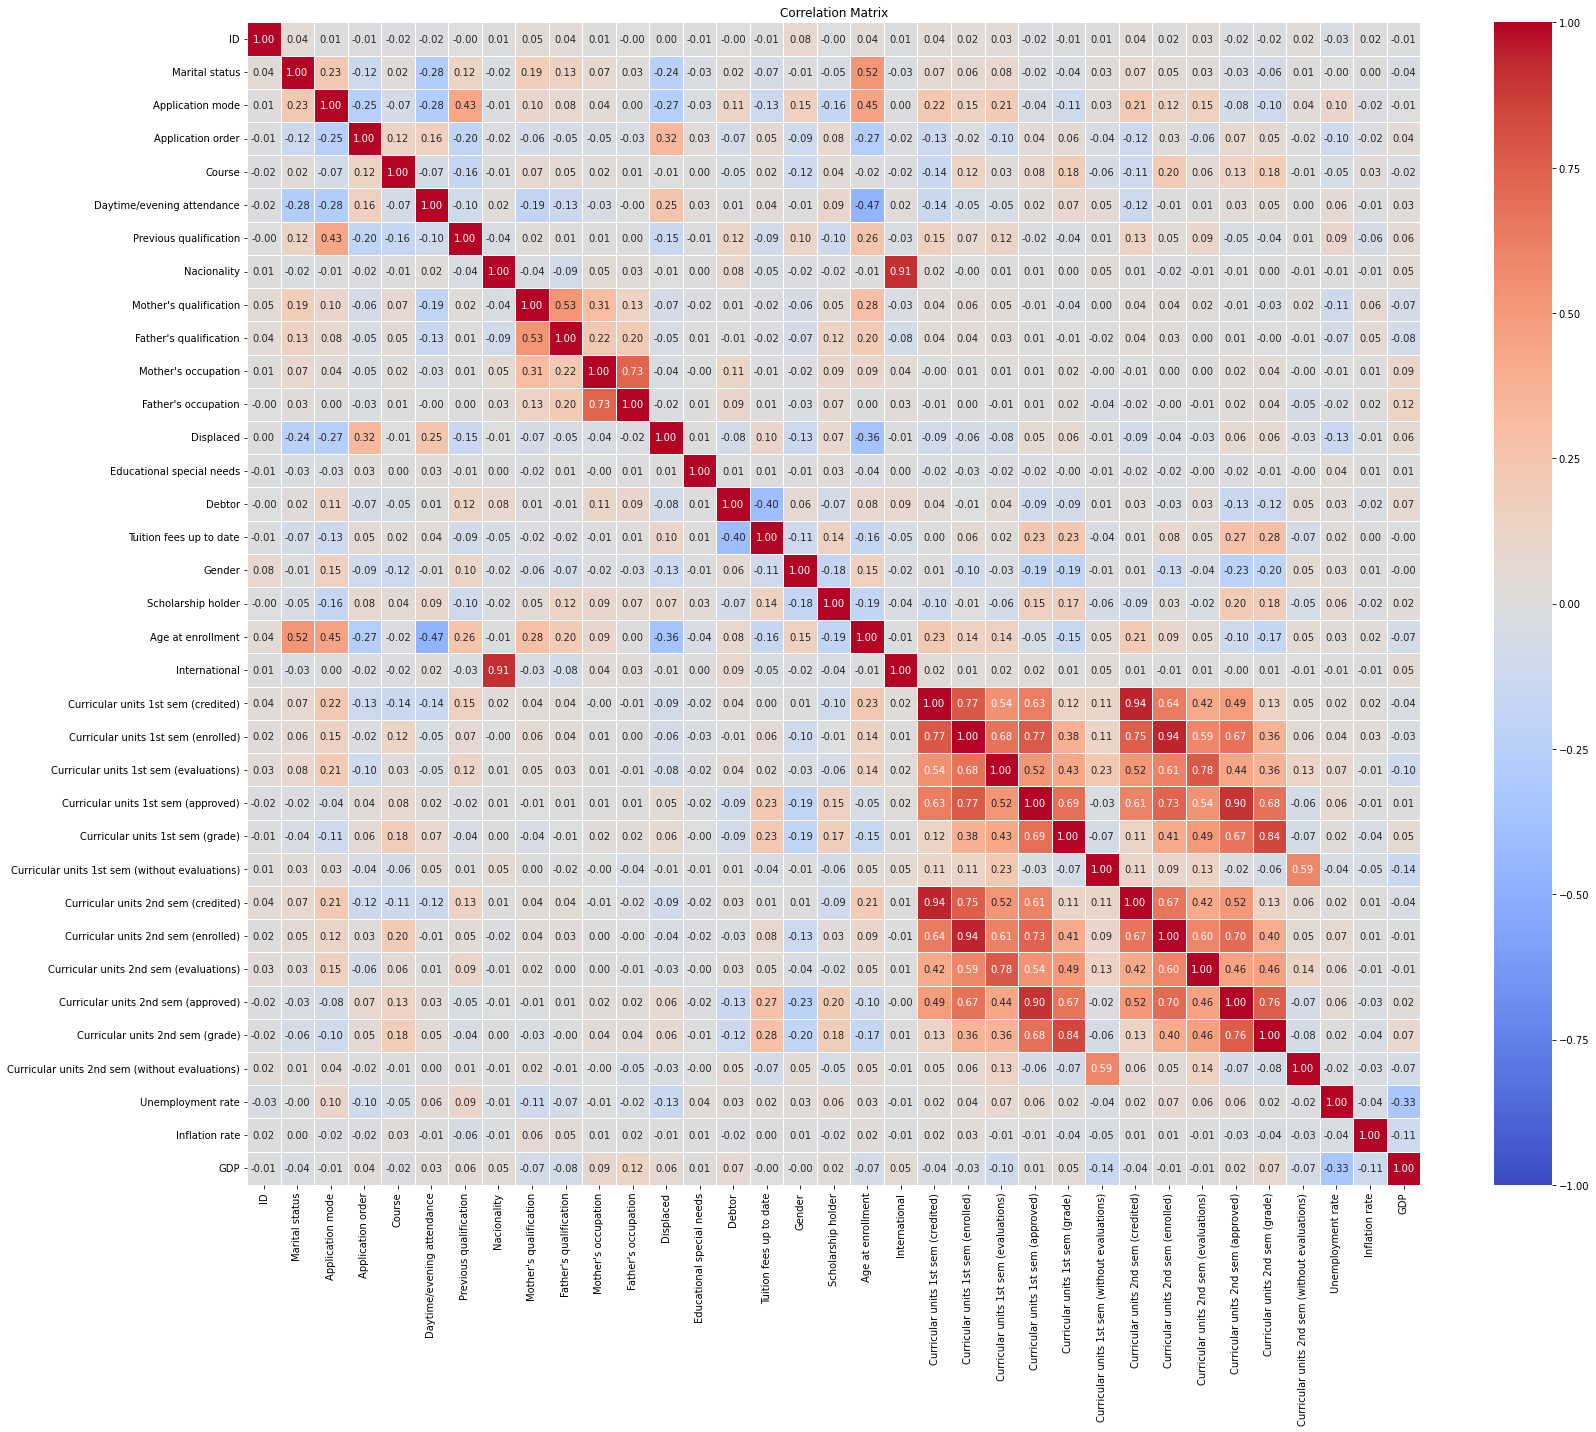

In [4]:
# calculate correlation matrix
corr_matrix = data.corr()

plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

To provide a more comprehensive overview and validate these findings, a correlation matrix was used for further analysis. The matrix confirmed the strong correlations between socioeconomic data and academic performance at the end of the 1st and 2nd semesters. Notably, there is a high correlation (0.91) between the international and nationality features, which can be attributed to their inherent nature. Regarding the target variable, some weak correlations were observed, such as those with Mother’s occupation and Previous qualification.

# **2. Data Preprocessing**

Based on the findings of the EDA, several preprocessing steps are required. Firstly, the target feature needs to be encoded into a label format suitable for machine learning algorithms. Secondly, the dataset must be loaded into a data loader and divided into training and testing sets, with the test set comprising 20% of the original dataset. Furthermore, a Random Forest model was employed for feature selection, serving multiple purposes: reducing dimensionality, improving computational efficiency, and identifying the most informative features for prediction. Lastly, Synthetic Minority Oversampling Technique was applied to balance the training data, addressing class imbalance issues and ensuring the model performs more effectively on minority classes by preventing biased predictions.

In [5]:
# install deep-forest
!pip install deep-forest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.7 MB/s eta 0:00:0000:0100:01


In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import joblib

import xgboost as xgb

from deepforest import CascadeForestClassifier

from lightgbm import LGBMClassifier

# load data
data = pd.read_csv("/kaggle/input/int-303-big-data-analytics-2425-s1/train.csv")

# use label encoder to encode the target column
label_encoder = LabelEncoder()
data['Target'] = label_encoder.fit_transform(data['Target'])


# divide the data into features and target
X = data.drop(columns=['Target']) 
y = data['Target']  

# divide the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=303)

# Use the random forest model to select supported features
feature_selector = RandomForestClassifier(n_estimators=200, min_samples_leaf=1, min_samples_split=2, random_state=303)
feature_selector.fit(X_train, y_train)

selector = SelectFromModel(feature_selector, threshold=0.02, prefit=True)
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)
print("Feature selection result's shape:", X_train.shape)

# Use SOMTE to balance the training data
smote = SMOTE(random_state=303)
X_train, y_train = smote.fit_resample(X_train, y_train)

Feature selection result's shape: (2831, 20)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


# **3. Model Building**

After preprocessing, this study employed four machine learning methods to train models for predicting student academic information. The four methods were Random Forest, XGBoost, LightGBM, and Deep Forest. The evaluation metrics mainly focused accuracy, F1 score, and Kaggle's competition score. After extensive training, ablation studies, and testing, the Random Forest model was selected as the optimal choice, achieving a Kaggle competition score of 0.81674.

All methods, except for Deep Forest, utilized grid search for hyperparameter optimization during the ablation study process. To reduce runtime, the current code version includes only the best-performing hyperparameters. For Deep Forest, which does not natively support grid search or similar interfaces (e.g., GridSearchCV), manual ablation studies were conducted to determine the optimal hyperparameters. Once grid search or manual optimization was completed, models trained with the identified optimal hyperparameters were used for predictions on the test set.

The evaluation metrics included precision, recall, F1-score, and support to provide a comprehensive assessment of model performance. These metrics ensured a balanced evaluation, capturing both the model's ability to correctly classify cases and its robustness in handling imbalanced data.

In [7]:
# Define the random forest model
rf_model = RandomForestClassifier(random_state=303)

# Define the hyperparameters to be tuned. Because the grid search is time-consuming, there only present the optimal hyperparameters.
param_grid = {
    'n_estimators': [200], 
    'max_depth': [20],  
    'min_samples_split': [2],  
    'min_samples_leaf': [1],  
    'bootstrap': [False]  
}

# Use grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-validation Score: {grid_search.best_score_}")

# Utlize the best model to predict the test data
best_rf_model = grid_search.best_estimator_

y_pred = best_rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

joblib.dump(best_rf_model, 'randomforest_model.pkl')

Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-validation Score: 0.813805920394693
Accuracy: 0.788135593220339
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       223
           1       0.53      0.50      0.51       121
           2       0.84      0.91      0.88       364

    accuracy                           0.79       708
   macro avg       0.73      0.72      0.72       708
weighted avg       0.78      0.79      0.78       708



['randomforest_model.pkl']

In [8]:
# XGBoost
# Define the hyperparameters to be tuned. Because the grid search is time-consuming, there only present the optimal hyperparameters.
param_grid = {
    'max_depth': [3],
    'learning_rate': [0.1],
    'n_estimators': [200],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Use grid search to find the best hyperparameters for XGBoost
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss'),
                           param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Utlize the best model to predict the test data
best_xgb_model = grid_search.best_estimator_

best_xgb_model.fit(X_train, y_train)

y_pred = best_xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

joblib.dump(best_xgb_model, 'xgb_model.pkl')

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Score: 0.7590759075907592
Accuracy: 0.7641242937853108
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.68      0.74       223
           1       0.46      0.45      0.45       121
           2       0.83      0.92      0.87       364

    accuracy                           0.76       708
   macro avg       0.70      0.68      0.69       708
weighted avg       0.76      0.76      0.76       708



['xgb_model.pkl']

In [9]:
# LightGBM
# Define the hyperparameters to be tuned. Because the grid search is time-consuming, there only present the optimal hyperparameters.
param_grid = {
    'max_depth': [7],
    'learning_rate': [0.1],
    'n_estimators': [200],
    'num_leaves': [31],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Use grid search to find the best hyperparameters for LightGBM
grid_search = GridSearchCV(estimator=LGBMClassifier(objective='multiclass', num_class=3),
                           param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

best_lgbm_model = grid_search.best_estimator_

best_lgbm_model.fit(X_train, y_train)

y_pred = best_lgbm_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

joblib.dump(best_lgbm_model, 'lgbm_model.pkl')

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.8}
Best Score: 0.779113625648279
Accuracy: 0.7796610169491526
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.78       223
           1       0.50      0.42      0.46       121
           2       0.84      0.91      0.88       364

    accuracy                           0.78       708
   macro avg       0.71      0.70      0.70       708
weighted avg       0.77      0.78      0.77       708



['lgbm_model.pkl']

In [10]:

# Define the deep forest model
df_model = CascadeForestClassifier(
    n_estimators=4,  
    random_state=42,
    verbose=1
)

df_model.fit(X_train, y_train)

y_pred = df_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

joblib.dump(df_model, 'deep_forest_model.pkl')

[2024-12-20 17:09:46.933] Start to fit the model:
[2024-12-20 17:09:46.933] Fitting cascade layer = 0 
[2024-12-20 17:09:51.960] layer = 0  | Val Acc = 83.239 % | Elapsed = 5.027 s
[2024-12-20 17:09:51.992] Fitting cascade layer = 1 
[2024-12-20 17:09:58.470] layer = 1  | Val Acc = 83.333 % | Elapsed = 6.478 s
[2024-12-20 17:09:58.500] Fitting cascade layer = 2 
[2024-12-20 17:10:04.659] layer = 2  | Val Acc = 83.357 % | Elapsed = 6.159 s
[2024-12-20 17:10:04.689] Fitting cascade layer = 3 
[2024-12-20 17:10:10.992] layer = 3  | Val Acc = 82.980 % | Elapsed = 6.303 s
[2024-12-20 17:10:10.992] Early stopping counter: 1 out of 2
[2024-12-20 17:10:11.022] Fitting cascade layer = 4 
[2024-12-20 17:10:17.359] layer = 4  | Val Acc = 82.343 % | Elapsed = 6.337 s
[2024-12-20 17:10:17.359] Early stopping counter: 2 out of 2
[2024-12-20 17:10:17.359] Handling early stopping
[2024-12-20 17:10:17.360] The optimal number of layers: 3
[2024-12-20 17:10:17.362] Start to evalute the model:
[2024-12-20

['deep_forest_model.pkl']

In [11]:
# load the best model for submission
submit_model = joblib.load('/kaggle/working/randomforest_model.pkl')

# load the test data and transform it using the feature selector
test_data = pd.read_csv('/kaggle/input/int-303-big-data-analytics-2425-s1/test.csv')
test_data = test_data.drop(columns=['Target'])

selector = SelectFromModel(feature_selector, threshold=0.02, prefit=True)
test_x = selector.transform(test_data)

y_pred = submit_model.predict(test_x)

# Encode the predicted labels back to original labels
label_mapping = {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}
y_pred_labels = [label_mapping[label] for label in y_pred]

# Create a submission dataframe
submission = pd.DataFrame({
    'ID': test_data['ID'],  
    'TARGET': y_pred_labels  
})

submission.to_csv('/kaggle/working/submission.csv', index=False)

print(submission.head())

     ID    TARGET
0  2050  Graduate
1     3   Dropout
2     4  Graduate
3  2054  Enrolled
4     7  Graduate


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
